In [5]:
!unzip dataset.zip

Archive:  dataset.zip
replace imbalanced_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!nvidia-smi


Sun Feb 25 16:20:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
import pandas as pd

imbalanced_data = pd.read_csv('/content/imbalanced_data.csv')
raw_data = pd.read_csv('/content/raw_data.csv')

imbalanced_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


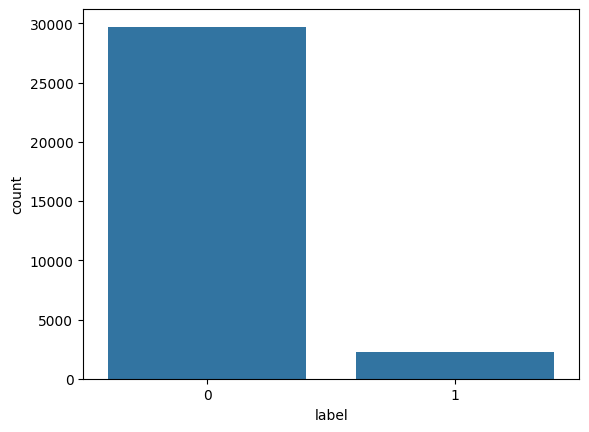

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=imbalanced_data)
plt.show()

In [9]:
imbalanced_data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

- 0 --> No Hate
- 1 --> Hate

In [10]:
imbalanced_data.drop(columns=['id'], inplace=True)

In [11]:
imbalanced_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [12]:
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [13]:
raw_data['class'].unique()

array([2, 1, 0])

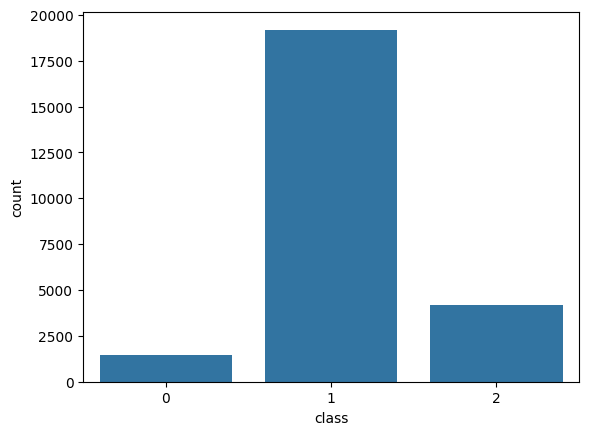

In [14]:
sns.countplot(x='class', data=raw_data)
plt.show()

- class 0: hate
- class 1: abusive
- class 2: no hate

In [15]:
raw_data['label'] = raw_data['class'].map({0: 1, 1:1, 2: 0})

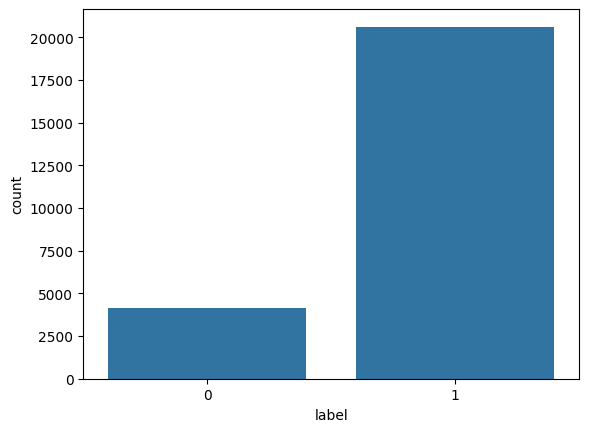

In [16]:
sns.countplot(x='label', data=raw_data)
plt.show()

In [17]:
raw_data.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet', 'label'],
      dtype='object')

In [18]:
imbalanced_data.columns

Index(['label', 'tweet'], dtype='object')

In [19]:
df = pd.concat([raw_data[['label', 'tweet']], imbalanced_data]).reset_index(drop=True)

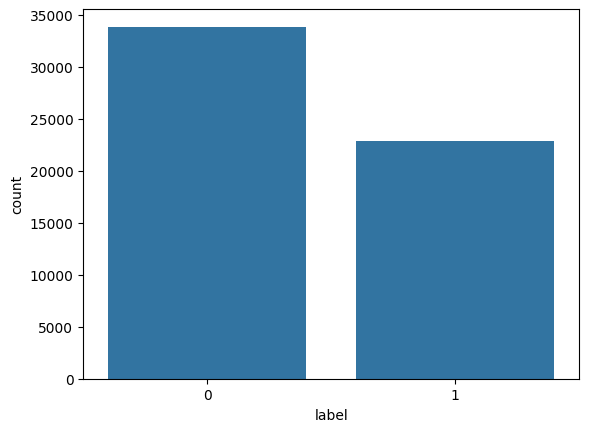

In [20]:
sns.countplot(x='label', data=df)
plt.show()

## Preprocessing

In [21]:
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [23]:
def data_cleaning(words):
  words = str(words).lower()
  words = re.sub('\[.*?\]', '', words)
  words = re.sub('https?://\S+|www\.\S+', '', words)
  words = re.sub('<.*?>+', '', words)
  words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
  words = re.sub('\n', '', words)
  words = re.sub('\w*\d\w*', '', words)
  words = [word for word in words.split(' ') if word not in stopword]
  words = ' '.join(words)
  words = [stemmer.stem(word) for word in words.split(' ')]
  words = ' '.join(words)

  return words

In [24]:
df['tweet'] = df['tweet'].map(data_cleaning)

In [25]:
x = df['tweet']
y = df['label']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [26]:
import tensorflow as tf
import keras

In [27]:
max_words = 50000
max_len = 300

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(x_train)

sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = tf.keras.utils.pad_sequences(sequences, maxlen=max_len)

In [37]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(max_words, 100, input_length=max_len))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 300, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5080501 (19.38 MB)
Trainable params: 5080501 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
history=model.fit(sequences_matrix, y_train, batch_size=128, epochs=2, validation_split=0.2)

Epoch 1/2
284/284 [==============================] - 349s 1s/step - loss: 0.3013 - accuracy: 0.8749 - val_loss: 0.1756 - val_accuracy: 0.9402
Epoch 2/2
284/284 [==============================] - 321s 1s/step - loss: 0.1525 - accuracy: 0.9468 - val_loss: 0.1625 - val_accuracy: 0.9441


In [39]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = tf.keras.utils.pad_sequences(test_sequences, maxlen=max_len)

In [40]:
accr = model.evaluate(test_sequences_matrix, y_test)

355/355 [==============================] - 30s 86ms/step - loss: 0.1671 - accuracy: 0.9396


In [41]:
lstm_prediction = model.predict(test_sequences_matrix)

355/355 [==============================] - 37s 105ms/step


In [42]:
res = []
for prediction in lstm_prediction:
  if prediction[0] < 0.5:
    res.append(0)
  else:
    res.append(1)

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
print(confusion_matrix(y_test, res))

[[6666  132]
 [ 553 3998]]


In [45]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
load_model = tf.keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
  load_tokenizer = pickle.load(handle)

In [51]:
test = 'What the fuck?'
test = [data_cleaning(test)]

print(test)

seq = tokenizer.texts_to_sequences(test)
padded = tf.keras.utils.pad_sequences(seq, maxlen=max_len)

print(seq)

pred = load_model.predict(padded)

print(f"pred: {pred}")
if pred<0.5:
  print("no hate")
else:
  print("hate and abuse")

['fuck']
[[11]]
1/1 [==============================] - 0s 203ms/step
pred: [[0.700333]]
hate and abuse


In [49]:
pred[0]

array([0.1256507], dtype=float32)